### Profiling Scanpy  for data of Zheng *et al.*, Nat. Comm. (2017)

This is the *Scanpy* benchmark for the *Cell Ranger* R analysis of Zheng *et al.*, Nat. Comms. (2017) available from https://github.com/10XGenomics/single-cell-3prime-paper. Compare the Scanpy version with the [Cell Ranger version of this notebook](zheng17_pbmc64k_cellranger_r.ipynb).

The pbmc64k data is freely available [[page](https://support.10xgenomics.com/single-cell/datasets/fresh_68k_pbmc_donor_a)/[file](https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/fresh_68k_pbmc_donor_a/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices.tar.gz)] from the 10x homepage or from the previous GitHub link.

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy as sc

sc.sett.verbosity = 0                # increase for more output
sc.sett.set_dpi(80)                  # low pixel number yields small inline figures
sc.sett.file_format_figures = 'png'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.sett.savefigs = False             # set to True if you want to save figures to `./figs/`

Output Scanpy version and initial usage of memory.

In [2]:
print('Running Scanpy version', sc.__version__, 'on', sc.logging.get_date())
sc.logging.print_memory_usage()

Running Scanpy version 0.1+24.g4b064be.dirty on 2017-05-15 18:27
Memory usage: current 0.12 GB, difference +0.12 GB


Only use the first n cells, set to 0 if you want all cells.

In [3]:
use_first_n_samples = 10000
full_sparse = False

Set the file paths.

In [4]:
filename_data = './data/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices/hg19/matrix.mtx'
filename_genes = './data/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices/hg19/genes.tsv'
filename_barcodes = './data/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices/hg19/barcodes.tsv'

Load the data. This takes a long time only when first reading the raw data from the `.mtx` text file. It's very fast after that.

In [5]:
%%time
adata = sc.read(filename_data).transpose()
adata.var_names = np.loadtxt(filename_genes, dtype='S')[:, 1]
adata.smp_names = np.loadtxt(filename_barcodes, dtype='S')
sc.logging.print_memory_usage()

Memory usage: current 0.41 GB, difference +0.29 GB
CPU times: user 1.96 s, sys: 403 ms, total: 2.36 s
Wall time: 2.36 s


Reduce the number of samples for scaling information.

In [6]:
if use_first_n_samples != 0:
    adata = adata[:use_first_n_samples]

Per-cell normalize the data matrix $X$ and identify highly-variable genes. 

In [7]:
%%time
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 0.71 GB, difference +0.30 GB
CPU times: user 1.39 s, sys: 218 ms, total: 1.61 s
Wall time: 1.62 s


Plot the dispersion relation.

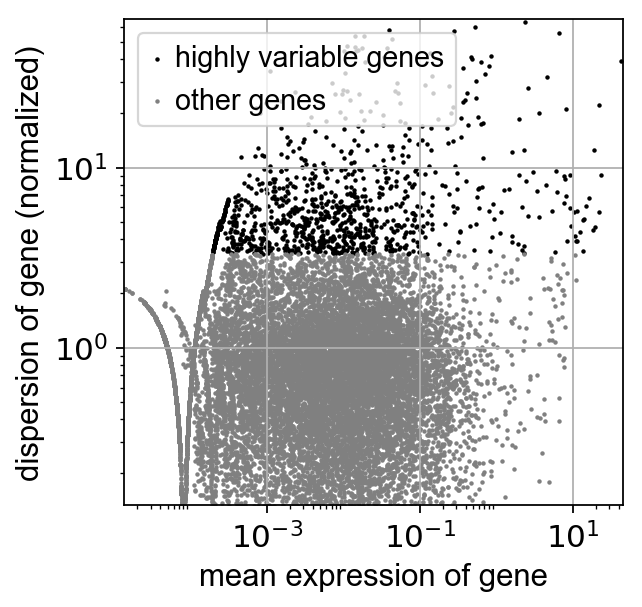

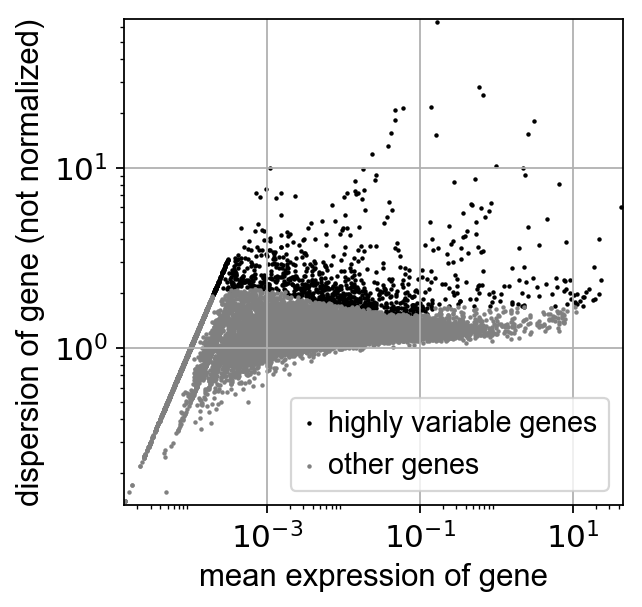

In [8]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

Compute PCA. Can be sped up considerably by setting `zero_center = False` below.

In [9]:
%%time
adata = adata[:, filter_result['gene_filter']]  # filter genes
sc.pp.normalize_per_cell(adata)  # need to redo normalization after filtering
sc.pp.log1p(adata)  # log transform: X = log(X + 1)
sc.pp.scale(adata, zero_center = not full_sparse)
sc.tl.pca(adata, n_comps=50, zero_center = not full_sparse)
sc.logging.print_memory_usage()

Memory usage: current 0.26 GB, difference -0.45 GB
CPU times: user 3.07 s, sys: 328 ms, total: 3.4 s
Wall time: 2.71 s


Compute tSNE (can be sped up significantly by installing https://github.com/DmitryUlyanov/Multicore-TSNE, which is automatically detected by Scanpy).

In [10]:
%%time
sc.tl.tsne(adata)
sc.logging.print_memory_usage()

Memory usage: current 0.37 GB, difference +0.11 GB
CPU times: user 40.5 s, sys: 485 ms, total: 40.9 s
Wall time: 30 s


Let us use the cell type labels generated by Zheng *et al.* by correlating gene expression with purified bulk data.

In [11]:
filename_labels = './data/storage/icbTTTdata/lukas.simon/DropFilesHere/PBMC68k.cellLables.txt'
bulk_labels = np.loadtxt(filename_labels, delimiter='\t', dtype='S')
adata.smp['bulk_labels'] = bulk_labels[:adata.n_smps]

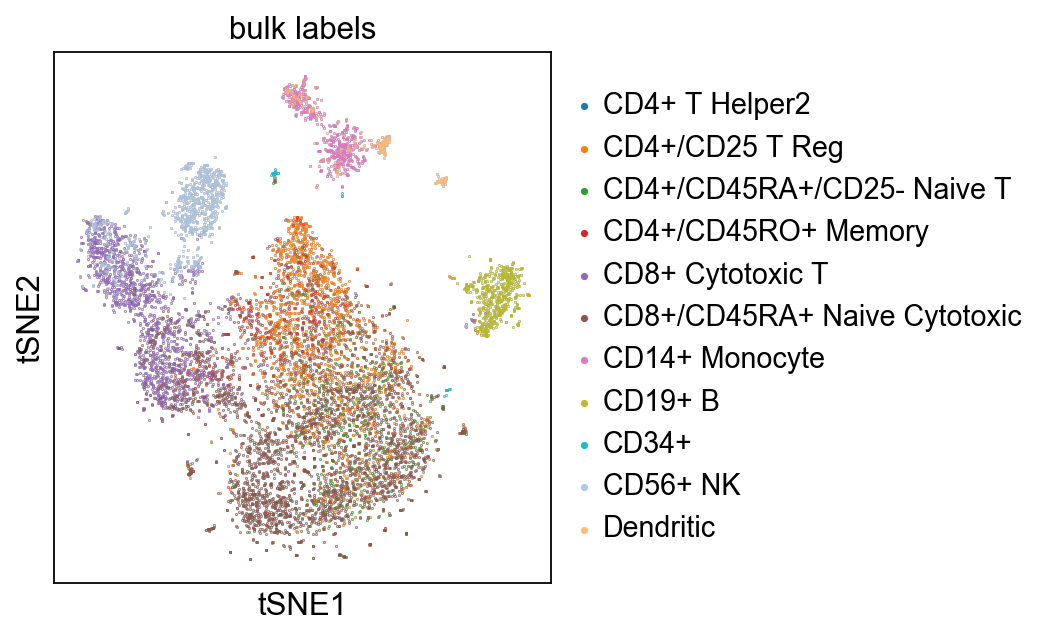

In [12]:
from matplotlib import pyplot as pl
axs = sc.pl.tsne(adata, color='bulk_labels', size=0.05, show=False)
axs[0].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), 
              markerscale=10)  # this is to increase the size of markers in the legend
pl.show()

### More visualizations and tools

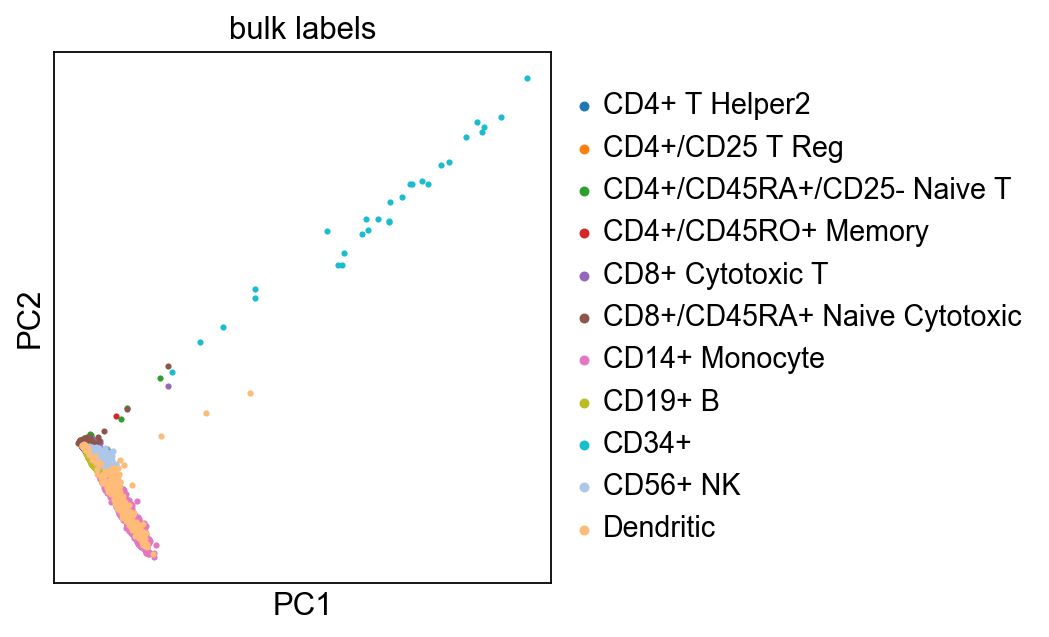

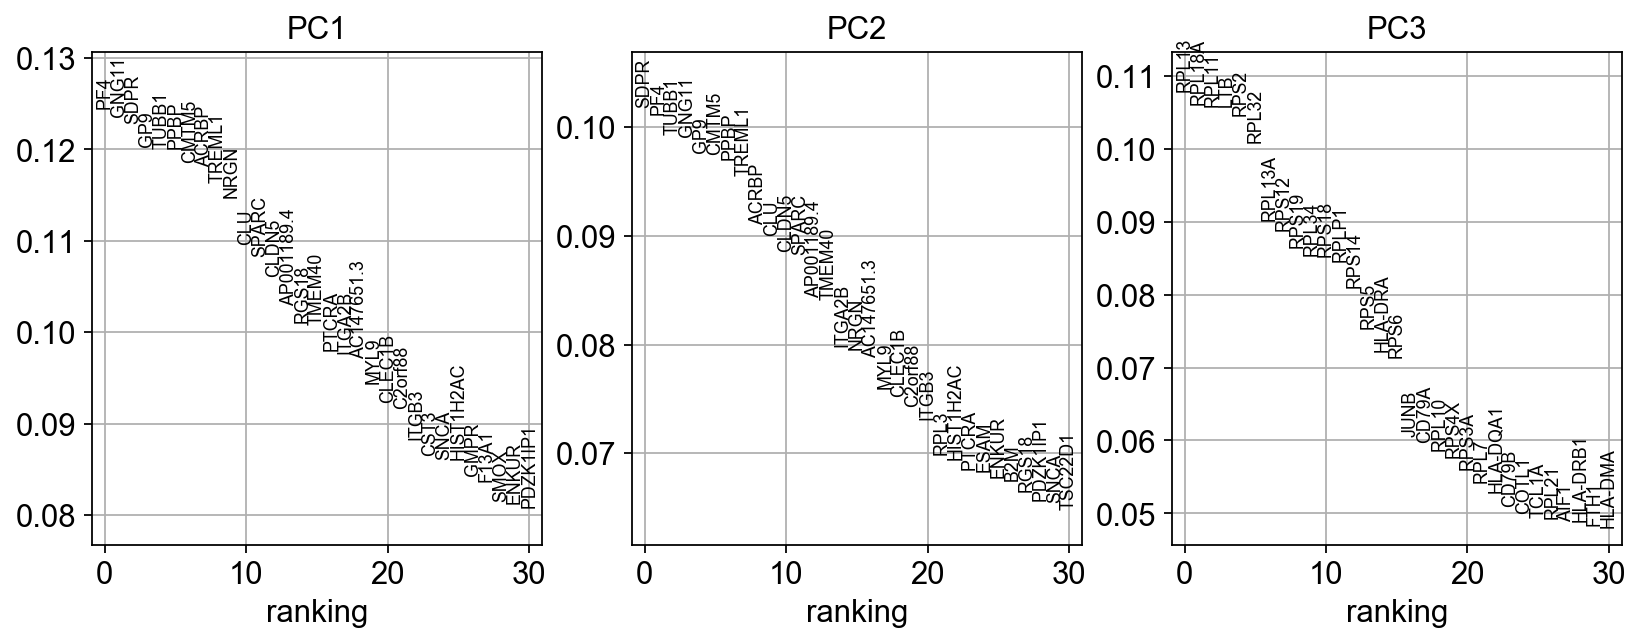

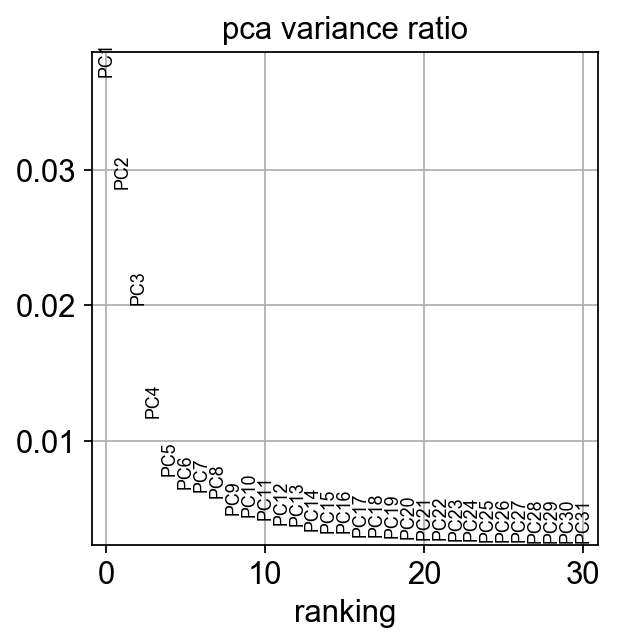

In [13]:
# plot the PCA and tSNE representation
sc.pl.pca(adata, color='bulk_labels')

In [14]:
%%time
sc.tl.diffmap(adata)
sc.logging.print_memory_usage()

Memory usage: current 0.33 GB, difference -0.04 GB
CPU times: user 8.28 s, sys: 610 ms, total: 8.89 s
Wall time: 7.3 s


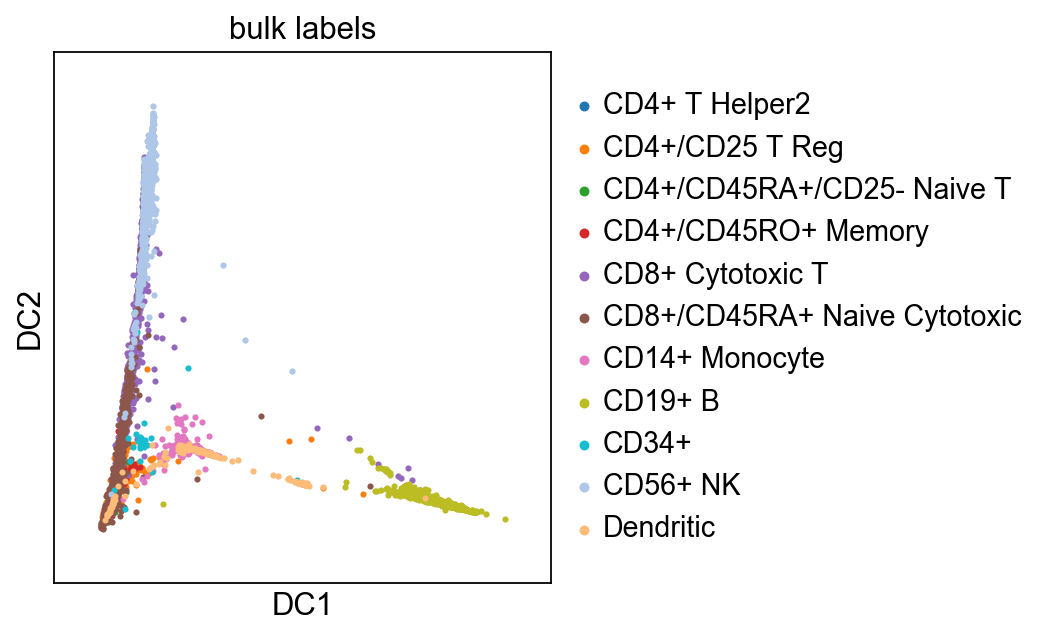

In [15]:
sc.pl.diffmap(adata, color='bulk_labels')

In [16]:
%%time
adata.add['xroot'] = adata.smp['X_pca'][np.where(adata.smp['bulk_labels'] == 'CD34+')[0][0]]
sc.tl.dpt(adata, n_branchings=1)
sc.logging.print_memory_usage()

Memory usage: current 0.73 GB, difference +0.40 GB
CPU times: user 9.44 s, sys: 432 ms, total: 9.88 s
Wall time: 10 s


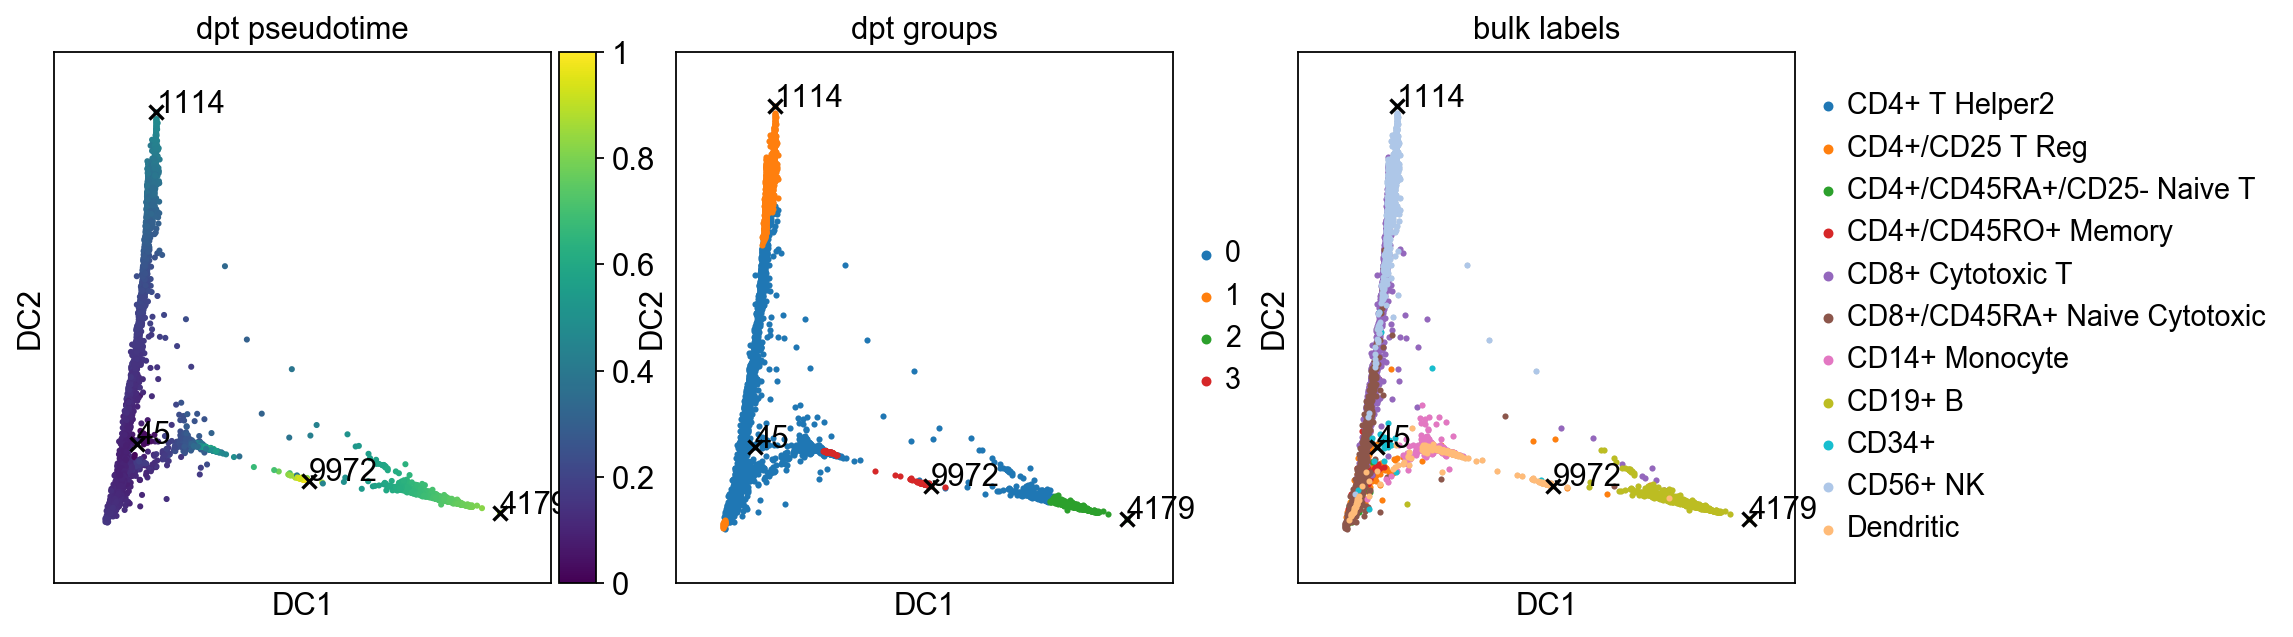

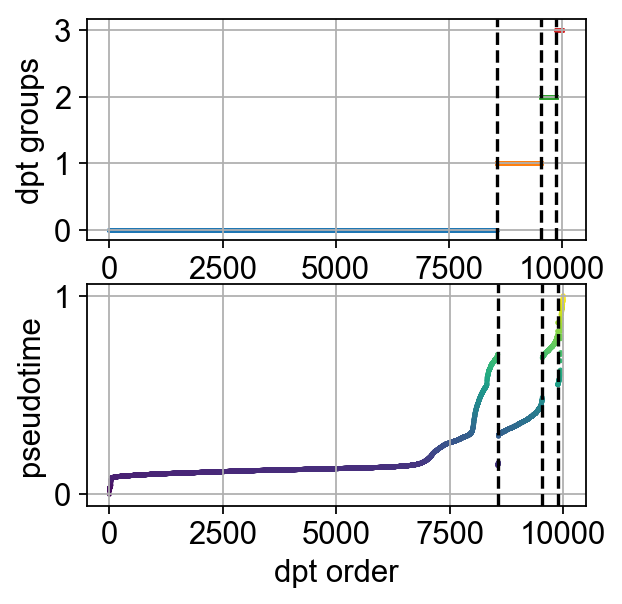

In [17]:
sc.pl.dpt(adata, color='bulk_labels')